## Using directional OCT to understand photoreceptor visibility in AMD

### Introduction

Investigators using adaptive optics (AO) retinal imaging instruments have reported reduced visibility of the cone photoreceptors overlying drusen as compared to those in unaffected portions of the same retinae or those in healthy retinae. Two compatible hypotheses have been offered to explain this phenomenon. Some have suggested that disease-related deformation of the photoreceptor outer segment (OS) reduces its ability to act as a wave guide, thus reducing the cell's familiar reflectance pattern. Others have suggested that drusen disorient the photoreceptors away from the eye's pupil, thus reducing the amount of reflected light that can be detected outside the eye.

In order to assess the contributions of these two potential factors to reduced photoreceptor visibility, we employed a custom research-grade OCT optical coherence tomography (OCT) system, along with a directional experimental protocol to acquire OCT images at a variety of positions in the pupil.

This repository is intended to illustrate the analytical approach that we employed.

### Methods

Directional OCT (dOCT) was realized by translating the OCT imaging beam across the horizontal diameter of the pupil. As described below, our analytical approach did not require knowledge of the beam's position in the pupil, so we acquired images from one edge of the pupil to the other in increments of 0.64 mm. At each location, between 1200 and 1600 B-scans were acquired. These were aligned and averaged using a custom semi-rigid body algorithm. For each pupil location, at least 50 B-scans were averaged to generate a single averaged image. Pupil locations were omitted from analysis if 50 B-scans could not be identified with sufficiently high correlation (e.g., when there was too much eye movement normal to the plane of the B-scan). In the resulting average images, a semi-automated method was used to segment the inner-outer segment (IS/OS) band and fit it with a smooth curve. (The cone outer segment (COST) band was not studied because a clear boundary between COST and retinal pigmented epithelium (RPE) was rarely observed above drusen, and contamination by light scattered from RPE was unavoidable.) 

At each A-scan of the average B-scan, the tangent to the IS/OS curve and the IS/OS amplitude (integrated over three pixels) was recorded. To account for the potentially confounding variable of overall image brightness (as a function of pupil position), the IS/OS amplitude was normalized by the amplitude of an overlying region in the outer nuclear layer (ONL), which was separately shown to have low directional dependence. Thus each amplitude value recorded represents the factor by which the IS/OS was more reflective than the corresponding ONL (in linear scale).

In addition, in each average B-scan, the boundaries of the drusen were determined visually, and each A-scan was labeled as 'drusen', 'non-drusen', or 'transitional'. Transitional zones were omitted from further analysis.

Thus for each pupil entry position, an **averaged B-scan** was recorded, along with records of the following parameters, all functions of lateral position in the B-scan (i.e., A-scan location):

* IS/OS axial location
* IS/OS angle
* IS/OS amplitude
* distance to druse margin

Pupil entry position was not monitored, but the beam was stepped across the pupil. Images and quantification were labeled arbitrarily between integers $-M$ and $N$, with positive values designated with 'p' and negative values designated with 'n'.

#### Visualizing data from one pupil position

The following example illustrates the data recorded from a single pupil entry position.

Text(0.5, 0, 'x location')

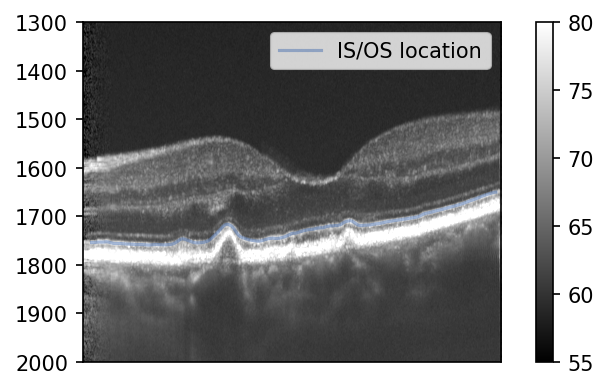

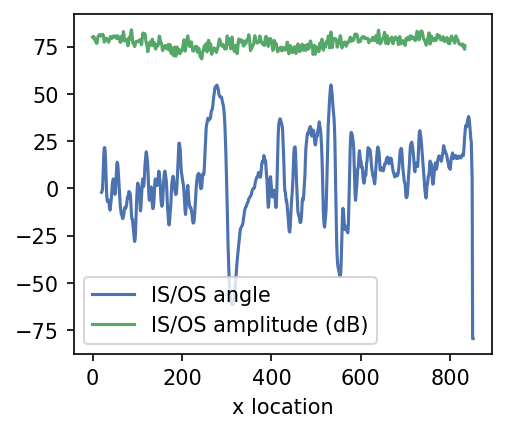

In [9]:
import numpy as np
from matplotlib import pyplot as plt
import os
plt.style.use('seaborn-deep')

pupil_position = 'p00'
subject_folder = './data/subject_02/'

# load B-scan and convert to dB
bscan_fn = os.path.join(subject_folder,'pupil_position_%s_average_bscan.npy'%pupil_position)
bscan = np.load(bscan_fn)
dB = 20*np.log10(bscan)
clim = (55,80)

# load IS/OS location
isos_location_fn = os.path.join(subject_folder,'pupil_position_%s_isos_axial_location.npy'%pupil_position)
isos_location = np.load(isos_location_fn)
x = np.arange(len(isos_location))

# load IS/OS angle
isos_angle_fn = os.path.join(subject_folder,'pupil_position_%s_isos_angle.npy'%pupil_position)
isos_angle = np.load(isos_angle_fn)

# load IS/OS amplitude
isos_amplitude_fn = os.path.join(subject_folder,'pupil_position_%s_isos_amplitude.npy'%pupil_position)
isos_amplitude = np.load(isos_amplitude_fn)

# show the B-scan and resulting IS/OS curve
plt.figure(figsize=(6,3),dpi=150)
plt.imshow(dB,clim=clim,cmap='gray')
plt.ylim((2000,1300))
plt.xticks([])
#plt.yticks([])
plt.colorbar()
plt.plot(x,isos_location,label='IS/OS location',alpha=0.5)
plt.legend()

# plot angle and amplitude as functions of x
plt.figure(figsize=(3.6,3),dpi=150)
plt.plot(x,isos_angle,label='IS/OS angle')
plt.plot(x,20*np.log10(isos_amplitude),label='IS/OS amplitude (dB)')
plt.legend()
plt.xlabel('x location')

#### Data aggregated over pupil positions

Data associated with the pupil-position-specific B-scans were aggregated, for drusen and non-drusen regions of the images separately. For each subject, these are stored in two files: 

* ```directionality_raw_data_drusen_centered.npy```
* ```directionality_raw_data_nondrusen_centered.npy```

Each contains an Nx2 matrix, where N represents the number of data points aggregated from all pupil positions. The two columns represent the IS/OS curve angle and normalized amplitude. Because the displacement of the Stiles-Crawford peak from the pupil center is not of interest, and because the pupil position was not tracked, angles for each subject were zero-centered by subtracting the average angle.

#### Visualization of aggregated data

The plot below illustrates the data aggregated from one subject's non-drusen IS/OS.



(0.0, 11.049298755640308)

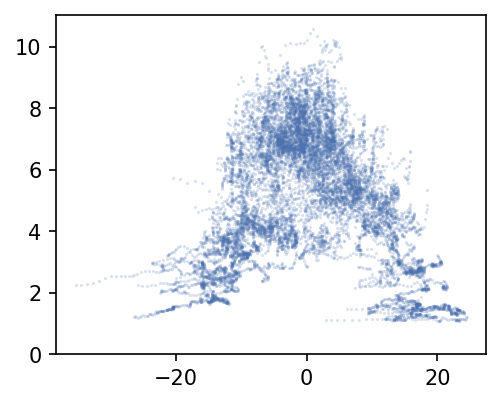

In [10]:
nondrusen_aggregate_fn = os.path.join(subject_folder,'directionality_raw_data_nondrusen_centered.npy')
angle_amplitude = np.load(nondrusen_aggregate_fn)
angle = angle_amplitude[:,0]
amplitude = angle_amplitude[:,1]


plt.figure(figsize=(3.7,3),dpi=150)
plt.plot(angle,amplitude,'.',alpha=0.2,markersize=1)
plt.gca().set_ylim(bottom=0)


#### Improving data visualization using rolling averaging

While a clear dependence of IS/OS amplitude on angle of illumination is visible in the figure above, substantial variance at all angles makes the relationship difficult to appreciate visually. To improve visualization, a rolling average technique was employed. A window of width $5.0^\circ$ was stepped across the range of angles present in a subject's measurements, in increments of $2.0^\circ$, and the average amplitude and standard deviation of amplitude were recorded at each location. The result of this averaging is shown below.

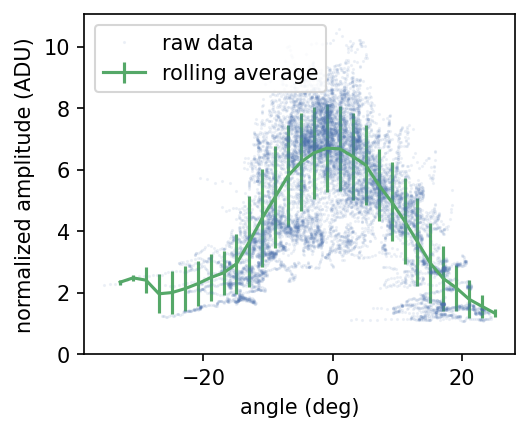

In [11]:
def rolling_average(angle,amp,window_width=5.0,step_size=2.0,diagnostics=False):
    
    # find the start and end angles
    t_start = np.min(angle)
    t_end = np.max(angle)

    window_centers = []
    amplitude_mean = []
    amplitude_std = []

    for t in np.arange(t_start,t_end+step_size,step_size):

        # find he indices in the angle array where the angle falls in our window
        idx = np.where(np.logical_and(angle>=t,angle<t+window_width))[0]

        if len(idx)>0:
            window_centers.append(t+window_width/2.0)        
            amplitude_mean.append(np.mean(amp[idx]))
            amplitude_std.append(np.std(amp[idx]))



    return np.array(window_centers),np.array(amplitude_mean),np.array(amplitude_std)

window_centers, amplitude_mean, amplitude_std = rolling_average(angle,amplitude)

plt.figure(figsize=(3.7,3),dpi=150)
# plot the raw data with low alpha
plt.plot(angle,amplitude,'.',alpha=0.1,markersize=1,label='raw data')

# plot the average with standard deviation bars
plt.errorbar(window_centers,amplitude_mean,amplitude_std,label='rolling average')
plt.xlabel('angle (deg)')
plt.ylabel('normalized amplitude (ADU)')
plt.gca().set_ylim(bottom=0)
plt.legend()

plt.show()
